## Imports

In [1]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel

from pprint import pprint

import spacy
from tqdm.notebook import tqdm

import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud
nlp = spacy.load('en_core_web_sm')


## Data Loading

Read the clean facts column (named entities and stopwords where removed from full facts) from df_dataset 

In [ ]:
df_dataset = pd.read_csv('df_dataset.csv', index_col = 0)
clean_facts = df_dataset['cleaned_facts']
clean_facts

## Data Preprocessing

Preprocessing involves lowercasing, removing numbers and punctuation, lemmatizing, removing single character strings, removing the word applicant and removing whitespace.

In [3]:
def further_preprocessing(text):
    
    # Convert the text to lowercase
    text = text.lower()

    # Remove anything that is not a word or space
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Lemmatize the text
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    # Remove single character strings
    tokens = [token for token in tokens if len(token) > 1]

    text = " ".join(tokens)

    # Remove the word "applicant"
    text = re.sub(r'\bapplicant\b', '', text)

    # Remove duplicate whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove any extra leading or trailing whitespace left after processing
    text = text.strip()
    
    return text

In [ ]:
clean_facts = clean_facts.apply(further_preprocessing)
clean_facts

Wordcloud to visualise most commonly found words

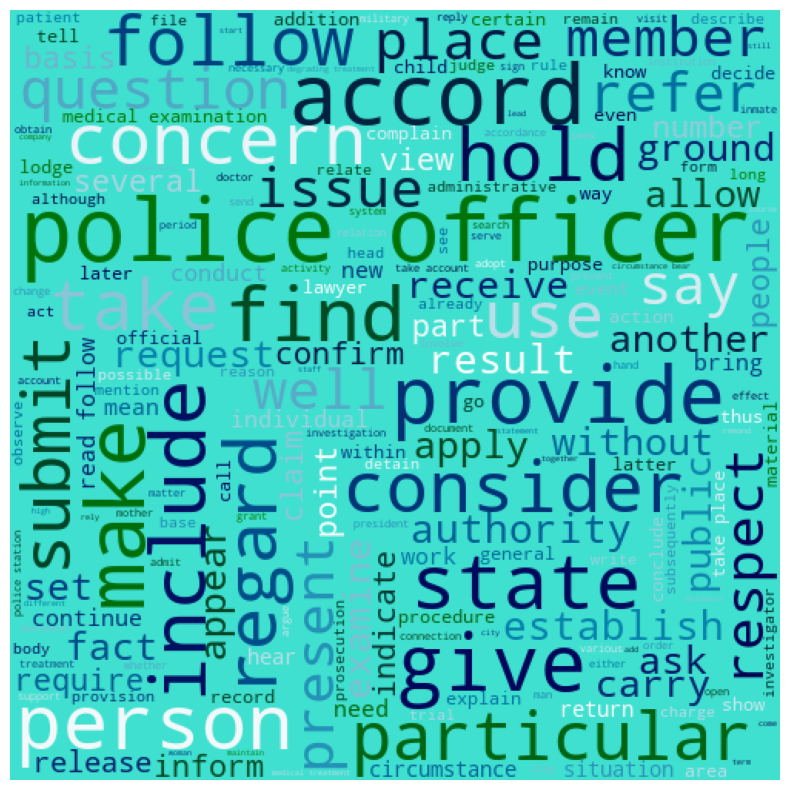

In [5]:
facts_data = ""
for fact in clean_facts:
    facts_data = facts_data+" "+fact

#ploting the word cloud
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(facts_data)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Create bigrams

In [5]:
sentence_stream = [doc.split(" ") for doc in clean_facts]

# If min_count=5, only those bigrams that appear at least 5 times in the corpus will be considered. 
#  Threshold controls how selective the model is in forming phrases. A higher threshold means that only word pairs with a strong association (high score) will be combined into a phrase
# https://stackoverflow.com/questions/46148182/issues-in-getting-trigrams-using-gensim
bigram = gensim.models.Phrases(sentence_stream, min_count=5, threshold = 20)  

In [6]:
def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

In [ ]:
clean_facts_bigrams = make_bigrams(sentence_stream)
clean_facts_bigrams

Remove words that are found frequently in the document (remove words that appear in threshold% of document or more)

In [8]:
# Setting no_above = threshold will remove words that appear in more than threshold% of the documents
def remove_frequent(facts, threshold):
    dictionary = corpora.Dictionary(facts)
    dictionary.filter_extremes(no_above=threshold)
    corpus = [dictionary.doc2bow(text) for text in facts]
    return dictionary, corpus

In [9]:
dictionary_03, corpus_03 = remove_frequent(clean_facts_bigrams,0.3)

## Metrics

In [10]:
def compute_coherence_values_lsi(facts, corpus, dictionary, n, onepass, power_iters, extra_samples):

    lsi_model = LsiModel(corpus=corpus, num_topics=n,
                    id2word=dictionary, onepass=onepass, power_iters = power_iters,
                    extra_samples = extra_samples, random_seed=42)
    
    coherence_model_lsi = CoherenceModel(model=lsi_model, 
                                         texts=facts,
                                         dictionary=dictionary, coherence='c_v')
    return coherence_model_lsi.get_coherence()


In [11]:
def calculate_topic_diversity(model, top_n):

    topic_words = []
    for topic_id in range(model.num_topics):
        words = [word for word, _ in model.show_topic(topic_id, topn=top_n)]
        topic_words.append(words)
    
    all_words = [word for sublist in topic_words for word in sublist]
    unique_words = set(all_words)
    
    topic_diversity = len(unique_words) / (model.num_topics * top_n)
    
    return topic_diversity


In [12]:
def calculate_coherence(model, facts, dictionary,metric):
    coherence_model = CoherenceModel(model=model, texts=facts,
                                        dictionary=dictionary, coherence=metric)
    return coherence_model.get_coherence()    

In [13]:
def calculate_topic_diversity_for_row(row, corpus, dictionary):
    # Ensure that the parameters are integers
    num_topics = int(row['Topics'])
    onepass = row['One Pass']
    power_iters = int(row['Power Iterations'])
    extra_samples = int(row['Extra Samples'])

    lsi_model = LsiModel(corpus=corpus, num_topics=num_topics,
                    id2word=dictionary, onepass=onepass, power_iters = power_iters,
                    extra_samples = extra_samples, random_seed=42)
    
    return calculate_topic_diversity(lsi_model, top_n=10)

In [14]:
def run_tests_lsi(min_topics, max_topics,facts, dictionary, corpus):

    step_size = 1
    topics_range = range(min_topics, max_topics+1, step_size)

    one_pass = [True,False]
    power_iters = [1,2,3,4,5,6,7]
    extra_samples = [50, 150, 250]

    # Results dictionary
    model_results = {
                    'Topics': [],
                    'One Pass': [],
                    'Power Iterations': [],
                    'Extra Samples': [],
                    'Coherence': []
                    }

    total_iterations = len(topics_range) * len(one_pass) * len(power_iters) * len(extra_samples) 

    with tqdm(total=total_iterations) as pbar:
        for n in topics_range:   
            for _pass in one_pass:
                for iter in power_iters:
                    for sample in extra_samples:
                        cv = compute_coherence_values_lsi(facts=facts, corpus=corpus,
                                                        dictionary=dictionary,
                                                        n=n, onepass = _pass, power_iters=iter, extra_samples = sample)
                            # Save the model results
                        model_results['Topics'].append(n)
                        model_results['One Pass'].append(_pass)
                        model_results['Power Iterations'].append(iter)
                        model_results['Extra Samples'].append(sample)
                        model_results['Coherence'].append(cv)

                        # Update the progress bar
                        pbar.update(1)

    # Save the results to a dataframe
    return pd.DataFrame(model_results)


In [15]:
df_0_3 = run_tests_lsi(1,20,clean_facts_bigrams,dictionary_03,corpus_03)

  0%|          | 0/840 [00:00<?, ?it/s]

In [37]:
df_0_3.sort_values(by='Coherence', ascending=False).head(20)

,Topics,One Pass,Power Iterations,Extra Samples,Coherence
54,2,True,5,50,0.721927
48,2,True,3,50,0.721927
45,2,True,2,50,0.721927
42,2,True,1,50,0.721927
23,1,False,1,250,0.684392
2,1,True,1,250,0.684392
33,1,False,5,50,0.684392
25,1,False,2,150,0.684392
26,1,False,2,250,0.684392
27,1,False,3,50,0.684392


In [16]:
df_0_3['Topic Diversity'] = df_0_3.apply(lambda row: calculate_topic_diversity_for_row(row, corpus_03, dictionary_03), axis=1)

df_0_3_sorted_by_diversity = df_0_3.sort_values(by='Topic Diversity', ascending=False)
df_0_3_sorted_by_diversity

,Topics,One Pass,Power Iterations,Extra Samples,Coherence,Topic Diversity
0,1,True,1,50,0.684392,1.000000
32,1,False,4,250,0.684392,1.000000
24,1,False,2,50,0.684392,1.000000
25,1,False,2,150,0.684392,1.000000
26,1,False,2,250,0.684392,1.000000
...,...,...,...,...,...,...
743,18,False,3,250,0.328453,0.322222
742,18,False,3,150,0.298790,0.322222
727,18,True,5,150,0.325064,0.322222
819,20,False,1,50,0.317669,0.315000


In [17]:
df_0_3_sorted_by_diversity.to_csv('df_0_3_sorted_by_diversity_lsi_all.csv')

In [19]:
best_model_5= LsiModel(corpus=corpus_03, num_topics=5,
                    id2word=dictionary_03, onepass=True, power_iters = 2,
                    extra_samples = 250, random_seed=42)
pprint(best_model_5.print_topics(num_words=30))

[(0,
  '0.233*"secret" + 0.191*"aircraft" + 0.186*"site" + 0.161*"military" + '
  '0.154*"territory" + 0.152*"president" + 0.148*"operation" + 0.141*"redact" '
  '+ 0.136*"flight" + 0.121*"source" + 0.110*"company" + 0.109*"security" + '
  '0.108*"service" + 0.106*"inquiry" + 0.097*"plane" + 0.097*"former" + '
  '0.092*"technique" + 0.092*"rendition" + 0.092*"plan" + 0.089*"control" + '
  '0.085*"transport" + 0.081*"datum" + 0.076*"location" + 0.075*"publish" + '
  '0.074*"building" + 0.068*"foreign" + 0.068*"cooperation" + 0.068*"search" + '
  '0.067*"investigate" + 0.066*"land"'),
 (1,
  '-0.280*"child" + 0.236*"secret" + 0.212*"aircraft" + 0.198*"site" + '
  '-0.189*"search" + -0.164*"tax" + 0.161*"redact" + 0.152*"flight" + '
  '-0.146*"company" + -0.115*"patient" + 0.111*"plane" + -0.107*"remand" + '
  '0.104*"rendition" + 0.103*"source" + 0.100*"territory" + 0.098*"military" + '
  '-0.095*"school" + 0.094*"technique" + -0.091*"parent" + -0.080*"woman" + '
  '-0.077*"city" + -0.07

In [47]:
calculate_topic_diversity(best_model_5,10)

0.58

In [52]:
calculate_coherence(best_model_5, clean_facts_bigrams, dictionary_03, 'c_v')

0.5722407034426938